# <font color='green'> WeRateDogs Wrangling Project </font>
* [Gather](#Gather)
 * [01. Loading "twitter-archive-enhanced" flat file to "df_archive"](#01.-Loading-"twitter-archive-enhanced"-flat-file-to-"df_archive")
 * [02. Downloading and loading "image_pridictions" flat file to "df_image"](#02.-Downloading-and-loading-"image_pridictions"-flat-file-to-"df_image")
 * [03. Querying specific "tweet_ids" extracted form the enhanced archive](#-03.-Querying-specific-"tweet_ids"-extracted-form-the-enhanced-archive-file)
* [Assess](#Assess)
 * [01. Assesing the first data frame "df_archive"](#01.-Assesing-the-first-data-frame-"df_archive")
 * [02. Assesing the second data frame "df_image"](#02.-Assesing-the-second-data-frame-"df_image")
 * [03. Assesing the third data frame "df_json"](#03.-Assesing-the-third-data-frame-"df_json")
* [Clean](#Clean)
 * [01. Pre-Cleaning](#Firstly,-we'll--get-rid-of-any-retweets,-replies,-no-dog-tweets-and-fixing-incorrect-rating-values)
 * [02. Cleaning Tidiness issues](#Solving-the-Tidiness-issues)
 * [03. Cleaning Quality issues](#Solving-the-Quality-issues:)
* [Storing](#Storing)
* [Visual Analysis](#Visual-Analysis)
 * [01. Dog rating distribution](#What-is-the-distribution-of-Pet-lovers'-rating,-what-rate-they-tend-to-give-thier-close-friends?)
 * [02. Top10 Avg. rating breeds](#What-are-the-top-10-breeds-based-on-average-rating?)
 * [03. Top10 breeds rating distribution](#For-the-identified-top-ten-breeds,-what-are-the-distribution-of-each-breed-rating?)
 * [04. Top3 breeds retweet/favorite count](#Which-one-of-the-top-3-breeds-has-the-most-fans-in-terms-of-"retweet_count"-and-"favorite_count"?)
 * [05. Top3 breeds tweeting source](#Now,-let's-finish-this-perspective-up-and-see-what's-the-most-common-tweeting-sources-for-each-one-of-them?)
 * [06. Common dog stage](#What-is-the-most-common-dog-stage?)
 * [07. Top dog stage retweet/favorite](#Which-Dog-Stage-has-the-most-"Retweet"-and-"Favorite"-count-among-the-others?)
 * [08. Most frequent Dog names](#What-is-the-most-frequent-dog-name?)
 * [09. Retweet vs Favorite](#What-is-the-corelation-between-"retweet-count"-and-"favorite-count"?)
 * [10. Dogs Word Cloud](#Finally-What-words-Dog-Lovers-used-commonly-to-share-their-moments-with-their-dogs?)
 

# Gather

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tweepy
import requests 
import json
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS
from timeit import default_timer as timer
import tqdm 

%matplotlib inline
pd.options.display.max_colwidth=1000
pd.options.display.max_rows=None
pd.options.display.precision=1

# from tqdm import tqdm_notebook 
# import matplotlib as mpl

### 01. Loading "twitter-archive-enhanced" flat file to "df_archive"

In [3]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2039,671547767500775424,NaN,NaN,2015-12-01 04:33:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Marley. She chews shoes then feels extremely guilty about it and refuses to look at them. 10/10 https://t.co/f99MV0htAV,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/671547767500775424/photo/1,https://twitter.com/dog_rates/status/671547767500775424/photo/1",10,10,Marley,None,None,None,None
1384,700796979434098688,NaN,NaN,2016-02-19 21:39:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Daniel. He's a neat pup. Exotic af. Custom paws. Leaps unannounced. Would totally pet. 7/10 daaamn Daniel https://t.co/5XaR0kj8cr,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700796979434098688/photo/1,7,10,Daniel,None,None,None,None


### 02. Downloading and loading "image_pridictions" flat file to "df_image"

In [4]:
url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r= requests.get(url)
with open(url.split('/')[-1], mode='wb') as file:
    file.write(r.content)

df_image= pd.read_csv(url.split('/')[-1], sep='\t')
df_image.sample(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1054,714251586676113411,https://pbs.twimg.com/media/CemIBt4WwAQqhVV.jpg,2,soft-coated_wheaten_terrier,0.8,True,Bedlington_terrier,1.8e-01,True,Great_Pyrenees,1.1e-02,True
809,692158366030913536,https://pbs.twimg.com/media/CZsKVxfWQAAXy2u.jpg,1,pug,1.0,True,swing,1.9e-02,False,toy_poodle,1.4e-02,True


###  <font color='red'> 03. Querying specific "tweet_ids" extracted form the enhanced archive file</font>

In [5]:
# #tweeter API query
# consumer_key = '474l8PWFPZyRGisP1KSbx51Ym'
# consumer_secret = 'tOp7sztLl3eSYuVmWl0xsvLzHUdxVkXAUpJyPu6wKcL11cBg4J'
# access_token = '1310054861027921920-LBiMrN2p7P1oNN6EvScvl8RJomWmcu'
# access_secret = 'gBPRyAnqwVkjnQSGVgoI3JDrrkFe0y3nIL7amdtiPBJJl'
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)
# api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
# #-----------------------------------------------------------------------------------------------------
# #If we got error we use this "tqdm.tqdm_notebook" instead of "tqdm.notebook.tqdm"
# tweet_ids= df_archive['tweet_id']
# fail_ids={}
# start=timer()
# with open('tweet_json.txt', mode='w') as file:
#     for tweet_id in tqdm.tqdm_notebook(tweet_ids):
#         try:
#             tweet= api.get_status(tweet_id, tweet_mode='extended')
#             json.dump(tweet._json, file)
#             file.write('\n')
#         except tweepy.TweepError as e:
#             fail_ids[tweet_id]=e
#             pass  
# end= timer()
# print('Number of Succeeded IDs: ', len(tweet_ids)-len(fail_ids))
# print('Number of Failed IDs: ', len(fail_ids))
# print('Time Consumed: ', end-start)

#### 04. Loading the extracted text file to "df_json"

In [6]:
df_list=[]
cols=['id','retweet_count','favorite_count']
with open('tweet_json.txt', mode='r', encoding='utf-8') as file:
    for line in file:
        line_json=json.loads(line)
        df_list.append({cols[0]:line_json[cols[0]], cols[1]:line_json[cols[1]], cols[2]:line_json[cols[2]]})

df_json= pd.DataFrame(df_list, columns=cols)
df_json.sample(2)

,id,retweet_count,favorite_count
461,815990720817401858,1012,4942
623,793226087023144960,2889,9850


# Assess

### 01. Assesing the first data frame "df_archive"

##### a) Quality issues:
- Columns `in_reply_to_status_id, in_reply_to_user_id` both have `78` retweets.
- Columns `retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp` have `181` retweets.
- Column `timestamp`  data type is not **datetime** format.
- Column `tweet_id ` data type is **int** instead of **str**.
- Row `45` rating should be 13.5/10 instead of 5/10.
- Row `1068` rating should be 14/10 instead of 9/11.
- Row `1165` rating should be 13/10 instead of 4/20.
- Row `1202` rating should be 11/10 instead of 50/50.
- Row `1662` rating should be 10/10 instead of 7/11.
- Row `2335` rating should be 9/10 instead of 1/2.
- Column `rating_numerator` should be **float** instead of **int**. (**however, this column will be dropped**)
- Row `516` has no rating.
- Outliers rating values (1776, 666, 420, 182, 75, 27, 26, and 0).
- Columns `doggo, floofer, pupper, and puppo` have **None** instead of **null**.
- Column `name` holds many values like `None, a, an and the` which isn't a real dog name. (**Hard to clean and will let it as it is**).
- Rename column `name` as it's some how ambiguous.
- Column `source` content is in **html** format.
- Column `expanded_urls` has `59` Null values. (**however, this column will be dropped**)
- Column `expanded_urls ` has many rows with more than one link. (**however, this column will be dropped**)


##### b) Tidiness issues:
- Column `text` holds double values "**tweet text** and **short url**".
- Column `expanded_urls` is redundant, **short url** is enough.
- Columns `in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp`don't belog to this table observational unit
- Row values displayed as columns headers `doggo, floofer, pupper, and puppo`.
- Add column named `dog_rating` insted of `rating_numerator`and `rating_denominator`.

In [7]:
df_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1968,673320132811366400,NaN,NaN,2015-12-06 01:56:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Frankie. He's wearing blush. 11/10 really accents the cheek bones https://t.co/iJABMhVidf,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/673320132811366400/photo/1,https://twitter.com/dog_rates/status/673320132811366400/photo/1,https://twitter.com/dog_rates/status/673320132811366400/photo/1,https://twitter.com/dog_rates/status/673320132811366400/photo/1",11,10,Frankie,None,None,None,None
2294,667138269671505920,NaN,NaN,2015-11-19 00:32:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Extremely intelligent dog here. Has learned to walk like human. Even has his own dog. Very impressive 10/10 https://t.co/0DvHAMdA4V,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667138269671505920/photo/1,10,10,None,None,None,None,None
455,818307523543449600,NaN,NaN,2017-01-09 04:04:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Moose. He doesn't want his friend to go back to college. 13/10 looks like you're staying home John https://t.co/LIhmM7i…,8.2e+17,4.2e+09,2017-01-04 01:05:59 +0000,"https://twitter.com/dog_rates/status/816450570814898180/photo/1,https://twitter.com/dog_rates/status/816450570814898180/photo/1",13,10,Moose,None,None,None,None
1935,674008982932058114,NaN,NaN,2015-12-07 23:33:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This pup is sad bc he didn't get to be the toy car. Also he has shitty money management skills. 10/10 still cute tho https://t.co/PiSXXZjDSJ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674008982932058114/photo/1,10,10,None,None,None,None,None
50,882627270321602560,NaN,NaN,2017-07-05 15:48:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stanley. He has his first swim lesson today. Doggle straps adjusted. Ready to go. 13/10 Phelps is nervous (IG: stanleythe_corgi) https://t.co/Nx52PGwH94,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882627270321602560/photo/1,13,10,Stanley,None,None,None,None


In [8]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.4e+03,7.8e+01,7.8e+01,1.8e+02,1.8e+02,2356.0,2356.0
mean,7.4e+17,7.5e+17,2.0e+16,7.7e+17,1.2e+16,13.1,10.5
std,6.9e+16,7.6e+16,1.3e+17,6.2e+16,9.6e+16,45.9,6.7
min,6.7e+17,6.7e+17,1.2e+07,6.7e+17,7.8e+05,0.0,0.0
25%,6.8e+17,6.8e+17,3.1e+08,7.2e+17,4.2e+09,10.0,10.0
50%,7.2e+17,7.0e+17,4.2e+09,7.8e+17,4.2e+09,11.0,10.0
75%,8.0e+17,8.3e+17,4.2e+09,8.2e+17,4.2e+09,12.0,10.0
max,8.9e+17,8.9e+17,8.4e+17,8.9e+17,7.9e+17,1776.0,170.0


In [10]:
#Check if there "notnull" rows in the column "in_reply_to_status_id" and "in_reply_to_user_id"
print(df_archive.in_reply_to_status_id.notnull().sum())
print(df_archive.in_reply_to_user_id.notnull().sum())

#Check if that the (notnull) rows in column 'in_reply_to_status_id' is the same in 'in_reply_to_user_id' column 
reply_status_index = df_archive[df_archive.loc[:, 'in_reply_to_status_id'].notnull()].index
reply_user_index = df_archive[df_archive.loc[:, 'in_reply_to_user_id'].notnull()].index
print('Same index for both columns: ', (reply_status_index == reply_user_index).all())

# Check if any of them has "None" value.
print('"in_reply_to_status_id" holds "None": ',df_archive.query('in_reply_to_status_id == "None"').shape[0])
print('"in_reply_to_user_id" holds "None": ',df_archive.query('in_reply_to_user_id == "None"').shape[0])

78
78
Same index for both columns:  True
"in_reply_to_status_id" holds "None":  0
"in_reply_to_user_id" holds "None":  0


In [11]:
#Check the (notnull) rows in the columns (retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp) 
status_id_index= df_archive[df_archive.loc[:, 'retweeted_status_id'].notnull()].index
user_id_index= df_archive[df_archive.loc[:, 'retweeted_status_user_id'].notnull()].index
timestamp_id_index= df_archive[df_archive.loc[:, 'retweeted_status_timestamp'].notnull()].index
print('Same index for all columns: ',((status_id_index == user_id_index) == (user_id_index == timestamp_id_index)).all() )

#Check if any of them has "None" value. 
print('"retweeted_status_id" holds "None": ', df_archive.query('retweeted_status_id == "None"').shape[0] )
print('"retweeted_status_user_id" holds "None": ',df_archive.query('retweeted_status_user_id == "None"').shape[0])
print('"retweeted_status_timestamp" holds "None": ',df_archive.query('retweeted_status_timestamp == "None"').shape[0])

Same index for all columns:  True
"retweeted_status_id" holds "None":  0
"retweeted_status_user_id" holds "None":  0
"retweeted_status_timestamp" holds "None":  0


In [12]:
#Visual check the rows of "rating denominator" column that not equal to '10'
df_archive[df_archive['in_reply_to_status_id'].isnull()].query('rating_denominator != 10').\
                                                             loc[:,['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80


In [13]:
#Visual check the rows of "rating numerator" column that less thno '10'
df_archive[df_archive['in_reply_to_status_id'].isnull()].query('rating_numerator < 10').\
                                                            loc[:,['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
229,848212111729840128,"This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",6,10
315,835152434251116546,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
462,817502432452313088,RT @dog_rates: Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet https:/…,7,10
485,814578408554463233,RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/…,9,10
599,798682547630837760,RT @dog_rates: Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.…,8,10
605,798576900688019456,RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,1,10
730,781661882474196992,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,5,10
745,780092040432480260,RT @dog_rates: This is Hank. He's mischievous af. Doesn't even know what he was trying to do here. 8/10 quit the shit Hank damn https://t.c…,8,10
764,777953400541634568,RT @dog_rates: Meet Gerald. He's a fairly exotic doggo. Floofy af. Inadequate knees tho. Self conscious about large forehead. 8/10 https://…,8,10


In [14]:
# Check the outlier values in the numerator that greater than "20" while the denominator is "10"
df_archive.query('rating_denominator == 10')['rating_numerator'].value_counts().sort_values()

666       1
1776      1
27        1
182       1
26        1
17        1
15        2
420       2
0         2
75        2
1         8
2         9
4        15
3        19
6        32
5        37
7        54
14       54
8       102
9       156
13      351
10      461
11      463
12      558
Name: rating_numerator, dtype: int64

In [15]:
#Test the "None" value in columns (doggo, floofer, pupper, and puppo)
df_archive.query('doggo == "None"').query('floofer == "None"').query('pupper == "None"').query('puppo == "None"').shape

(1976, 17)

In [16]:
#Display the different values in column "name"
df_archive.name.value_counts()

None              745
a                  55
Charlie            12
Oliver             11
Lucy               11
Cooper             11
Tucker             10
Penny              10
Lola               10
Winston             9
Bo                  9
the                 8
Sadie               8
Daisy               7
an                  7
Toby                7
Bailey              7
Buddy               7
Jack                6
Koda                6
Scout               6
Jax                 6
Dave                6
Bella               6
Leo                 6
Milo                6
Stanley             6
Oscar               6
Rusty               6
Finn                5
Sammy               5
George              5
Alfie               5
very                5
Gus                 5
Oakley              5
Larry               5
Chester             5
Phil                5
Louis               5
Sunny               5
Bentley             5
Archie              4
Reggie              4
one                 4
Boomer    

In [17]:
#Check "source" content
df_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [18]:
#Check (null) values in the column 'expanded_urls'.
df_archive.expanded_urls.isnull().sum()

59

In [19]:
#Check 'expanded_urls' contnet
df_archive.sample(5)['expanded_urls']

1570                                      https://vine.co/v/iOuMphL5DBY
1257                                      https://vine.co/v/iw9hUFAMerV
2318    https://twitter.com/dog_rates/status/666454714377183233/photo/1
1694    https://twitter.com/dog_rates/status/681281657291280384/photo/1
1149    https://twitter.com/dog_rates/status/726828223124897792/photo/1
Name: expanded_urls, dtype: object

In [20]:
#Check "text" column content
df_archive.text.sample(3).tolist()

['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
 "I swear to god if we get sent another Blue Madagascan Peacock we'll deactivate. We 👏 Only 👏 Rate 👏 Dogs... 9/10 https://t.co/bbta2Q4URK",
 "Say hello to Boomer. He's a sandy pupper. Having a h*ckin blast. 12/10 would pet passionately https://t.co/ecb3LvExde"]

### 02. Assesing the second data frame "df_image"

##### a) Quality issues:
- Column `tweet_id ` data type is **int** instead of **str**.
- There are tweets with images not related to dogs.
- Breed names contain underscore and not in **title** format.


##### b) Tidiness issues:
- Add columns `dog_breed, and conf_breed` of the most confident True dogs images instead of the predictions columns.

In [21]:
df_image.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
593,679475951516934144,https://pbs.twimg.com/media/CW37xZbUoAAUXe5.jpg,1,Maltese_dog,1.5e-01,True,toy_poodle,1.4e-01,True,West_Highland_white_terrier,1.1e-01,True
1103,721503162398597120,https://pbs.twimg.com/media/CgNLS1PW8AAxWSN.jpg,3,Pomeranian,1.0e+00,True,Chihuahua,1.2e-03,True,Pekinese,7.8e-04,True
1586,797971864723324932,https://pbs.twimg.com/media/CxL3IWeVEAAAIE2.jpg,1,American_Staffordshire_terrier,4.9e-01,True,Chihuahua,3.1e-01,True,Staffordshire_bullterrier,7.3e-02,True
109,667885044254572545,https://pbs.twimg.com/media/CUTN5V4XAAAIa4R.jpg,1,malamute,8.9e-02,True,golden_retriever,8.7e-02,True,muzzle,7.5e-02,False
1023,710283270106132480,https://pbs.twimg.com/media/Cdtu3WRUkAAsRVx.jpg,2,Shih-Tzu,9.3e-01,True,Lhasa,3.1e-02,True,Tibetan_terrier,9.0e-03,True


In [22]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.1e+03,2075.0,2.1e+03,2.1e+03,2.1e+03
mean,7.4e+17,1.2,5.9e-01,1.3e-01,6.0e-02
std,6.8e+16,0.6,2.7e-01,1.0e-01,5.1e-02
min,6.7e+17,1.0,4.4e-02,1.0e-08,1.7e-10
25%,6.8e+17,1.0,3.6e-01,5.4e-02,1.6e-02
50%,7.1e+17,1.0,5.9e-01,1.2e-01,4.9e-02
75%,7.9e+17,1.0,8.4e-01,2.0e-01,9.2e-02
max,8.9e+17,4.0,1.0e+00,4.9e-01,2.7e-01


In [24]:
#Checking images that not relate to dogs 
df_image.query('p1_dog == False').query('p2_dog == False').query('p3_dog == False').shape

(324, 12)

In [25]:
#Display breed names in "p1" as one of the breed columns
df_image.p1.value_counts()

golden_retriever                  150
Labrador_retriever                100
Pembroke                           89
Chihuahua                          83
pug                                57
chow                               44
Samoyed                            43
toy_poodle                         39
Pomeranian                         38
cocker_spaniel                     30
malamute                           30
French_bulldog                     26
miniature_pinscher                 23
Chesapeake_Bay_retriever           23
seat_belt                          22
Staffordshire_bullterrier          20
German_shepherd                    20
Siberian_husky                     20
Cardigan                           19
web_site                           19
teddy                              18
Eskimo_dog                         18
Shetland_sheepdog                  18
beagle                             18
Maltese_dog                        18
Shih-Tzu                           17
Lakeland_ter

### 03. Assesing the third data frame "df_json"

##### a) Quality issues:
- Column `id ` data type is **int** instead of **str**.
- Rename column `id` to be `tweet_id`.

In [26]:
df_json.sample(5)

,id,retweet_count,favorite_count
1177,716447146686459905,5696,12710
1578,685973236358713344,510,2057
1655,682032003584274432,1946,6437
1190,715200624753819648,1821,5012
1452,693629975228977152,777,2392


In [27]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [28]:
df_json.describe()

,id,retweet_count,favorite_count
count,2.3e+03,2331.0,2331.0
mean,7.4e+17,2644.0,7427.8
std,6.8e+16,4471.5,11533.8
min,6.7e+17,1.0,0.0
25%,6.8e+17,536.0,1292.0
50%,7.2e+17,1236.0,3228.0
75%,8.0e+17,3066.0,9087.0
max,8.9e+17,75972.0,153336.0


# Clean

In [29]:
df_archive_clean = df_archive.copy()
df_image_clean = df_image.copy()
df_json_clean = df_json.copy()

### Firstly, we'll  get rid of any retweets, replies, no dog tweets and fixing incorrect rating values

### - `df-archive`
 - Row `45` rating should be 13.5/10 instead of 5/10.
 - Row `1165` rating should be 13/10 instead of 4/20.
 - Row `1202` rating should be 11/10 instead of 50/50.
 - Row `1662` rating should be 10/10 instead of 7/11.
 - Row `1068` rating should be 14/10 instead of 9/11.
 - Row `2335` rating should be 9/10 instead of 1/2.
 - Columns `in_reply_to_status_id, in_reply_to_user_id` both have `78` retweets.
 - Columns `retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp` have `181` retweets.
 
### - `df-image`
 - There are tweets with images not related to dogs.

### `df_archive`
##### Define
We'll adjust below rows value before proceeding in the cleaning process,
- Row `45` rating should be 13.5/10 instead of 5/10.
- Row `1165` rating should be 13/10 instead of 4/20.
- Row `1202` rating should be 11/10 instead of 50/50.
- Row `1662` rating should be 10/10 instead of 7/11.
- Row `1068` rating should be 14/10 instead of 9/11.
- Row `2335` rating should be 9/10 instead of 1/2.

##### Code

In [30]:
fx_indxs=[45,1165,1202,1662,1068,2335]
num_vals=[13.5,13,11,10,14,9]
for indx in fx_indxs:
    df_archive_clean['rating_numerator'].loc[indx]=num_vals[fx_indxs.index(indx)]
    df_archive_clean['rating_denominator'].loc[indx]=10

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


##### Test

In [31]:
for indx in fx_indxs:
    print(df_archive_clean['rating_numerator'].loc[indx],'/',df_archive_clean['rating_denominator'].loc[indx])

13.5 / 10
13.0 / 10
11.0 / 10
10.0 / 10
14.0 / 10
9.0 / 10


### `df_archive`
##### Define
As we only looking for original tweets with image not niether retweets nor replies.
Columns `in_reply_to_status_id, in_reply_to_user_id` both have `78` retweets will be dropped.

##### Code

In [32]:
del_rows1= df_archive_clean[df_archive_clean.loc[:, 'in_reply_to_status_id'].notnull()].index
df_archive_clean.drop(del_rows1, inplace=True)
df_archive_clean= df_archive_clean.reset_index(drop=True)

##### Test

In [33]:
print('df_archive_clean rows before cleaning is: ', df_archive.shape[0])
print('df_archive_clean rows after cleaning is: ', df_archive_clean.shape[0])
print('Sum of "notnull" in column "in_reply_to_status_id" is: ',df_archive_clean.in_reply_to_status_id.notnull().sum())

df_archive_clean rows before cleaning is:  2356
df_archive_clean rows after cleaning is:  2278
Sum of "notnull" in column "in_reply_to_status_id" is:  0


### `df_archive`
##### Define
We will drop `181` retweets  in columns `retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp`.

##### Code

In [34]:
del_rows2= df_archive_clean[df_archive_clean.loc[:, 'retweeted_status_id'].notnull()].index
df_archive_clean.drop(del_rows2, inplace=True)
df_archive_clean= df_archive_clean.reset_index(drop= True)

##### Test

In [35]:
print('df_archive_clean rows before cleaning is: ', df_archive.shape[0]-78)
print('df_archive_clean rows after cleaning is: ', df_archive_clean.shape[0])
print('Sum of "notnull" in column "retweeted_status_id" is: ',df_archive_clean.retweeted_status_id.notnull().sum())

df_archive_clean rows before cleaning is:  2278
df_archive_clean rows after cleaning is:  2097
Sum of "notnull" in column "retweeted_status_id" is:  0


### `df_image`
##### Define
There are tweets with images not related to dogs. So, we'll to drop them as we only consider dogs tweets.

##### Code

In [36]:
del_rows3= df_image_clean.query('p1_dog == False').query('p2_dog == False').query('p3_dog == False').index
df_image_clean.drop(del_rows3, inplace= True)
df_image_clean= df_image_clean.reset_index(drop= True)

##### Test

In [37]:
df_image_clean.query('p1_dog == False').query('p2_dog == False').query('p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [38]:
df_image_clean.query('p1_dog == False').query('p2_dog == False').query('p3_dog == False').shape

(0, 12)

### Solving the Tidiness issues

### - `df_archive`
 - Column `text` holds double values "**tweet text** and **short url**".
 - Column `expanded_urls` is redundant, **short url** is enough.
 - Columns `in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp`don't belog to this table observational unit
 - Row values displayed as columns headers `doggo, floofer, pupper, and puppo`.
 - Add column named `dog_rating` insted of `rating_numerator, rating_denominator`
 
 
### - `df_image`
 - Add columns `dog_breed and conf_breed` of the most confident True dogs images instead of the predictions columns.

### `df_archive`
##### Define
Column `text` holds double values "**tweet text** and **short url**". So, we will extarct this "**short url**" to a new column with this name.

##### Code

In [39]:
df_archive_clean['short_url']= df_archive_clean['text'].apply(lambda x: x.split(' ')[-1])
df_archive_clean['text']= df_archive_clean['text'].apply(lambda x: x.split(' https://')[0])

##### Test

In [40]:
df_archive_clean.loc[:,['text','short_url']].sample(5)

,text,short_url
722,This is Winnie. She's not a fan of the fast moving air. 11/10 objects in mirror may be more fluffy than they appear,https://t.co/FyHrk20gUR
90,This is Harry. His ears are activated one at a time. Incredibly rare to witness in person. Very special moment here. 13/10 blessed as h*ck,https://t.co/ejHvGDfWoa
1948,This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10,https://t.co/EM5fDykrJg
60,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici),https://t.co/UDT7ZkcTgY
480,This is Dobby. I can't stop looking at her feet. 12/10 would absolutely snug,https://t.co/LhzPWv6rTv


### `df_archive`
#####  Define
Drop the redundant column `expanded_urls` as we care for the tweet **url** only and it's alredy extracted from the `text` column.

##### Code

In [41]:
df_archive_clean.drop(['expanded_urls'], axis=1, inplace=True)

##### Test

In [42]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   rating_numerator            2097 non-null   float64
 10  rating_denominator          2097 non-null   int64  
 11  name                        2097 non-null   object 
 12  doggo                       2097 non-null   object 
 13  floofer                     2097 

### `df_archive`
#####  Define
After omitting any rows of retweets/replies, columns `in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp` are not belong to this table observational unit. So we need to drop them all.

##### Code

In [43]:
del_cols1=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id','retweeted_status_timestamp']
df_archive_clean.drop(del_cols1, axis=1, inplace=True)

##### Test

In [44]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2097 non-null   int64  
 1   timestamp           2097 non-null   object 
 2   source              2097 non-null   object 
 3   text                2097 non-null   object 
 4   rating_numerator    2097 non-null   float64
 5   rating_denominator  2097 non-null   int64  
 6   name                2097 non-null   object 
 7   doggo               2097 non-null   object 
 8   floofer             2097 non-null   object 
 9   pupper              2097 non-null   object 
 10  puppo               2097 non-null   object 
 11  short_url           2097 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 196.7+ KB


### `df_archive`
#####  Define
Row values displayed as columns headers `doggo, floofer, pupper, and puppo`. So, we'll replace any **None** value with **null** then combine them all in one categorical column named `dog_stage` and, in the new column, will replace any **blank** with **null** then will drop the original columns.

##### Code

In [45]:
stg_cols=['doggo','floofer','pupper','puppo']
for stg in stg_cols:
    df_archive_clean[stg]=df_archive_clean[stg].replace('None',np.nan)
df_archive_clean['dog_stage']=df_archive_clean[stg_cols].apply(lambda x: '-'.join(x.dropna()),axis =1).astype('category')
df_archive_clean['dog_stage']= df_archive_clean['dog_stage'].replace('',np.nan)
df_archive_clean= df_archive_clean.drop(stg_cols, axis=1)

##### Test

In [46]:
df_archive_clean.dog_stage.dtypes, df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            2097 non-null   int64   
 1   timestamp           2097 non-null   object  
 2   source              2097 non-null   object  
 3   text                2097 non-null   object  
 4   rating_numerator    2097 non-null   float64 
 5   rating_denominator  2097 non-null   int64   
 6   name                2097 non-null   object  
 7   short_url           2097 non-null   object  
 8   dog_stage           336 non-null    category
dtypes: category(1), float64(1), int64(2), object(5)
memory usage: 133.6+ KB


(CategoricalDtype(categories=['doggo', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo',
                   'floofer', 'pupper', 'puppo'],
                  ordered=False),
 None)

### `df_archive`
##### Define.
To avoid massive variance in users' rating in terms of values in numerator and denominator, and in order to have consistent rating for coming analysis, we'll add a column named `dog_rating` to be equal to `rating_numerator/rating_denominator * 10` insted of the columns `rating_numerator`and `rating_denominator`.

##### Code

In [47]:
df_archive_clean['dog_rating']= (df_archive_clean['rating_numerator'] / df_archive_clean['rating_denominator']) * 10
df_archive_clean.drop(['rating_numerator','rating_denominator'], axis=1, inplace=True)

##### Test

In [48]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   tweet_id    2097 non-null   int64   
 1   timestamp   2097 non-null   object  
 2   source      2097 non-null   object  
 3   text        2097 non-null   object  
 4   name        2097 non-null   object  
 5   short_url   2097 non-null   object  
 6   dog_stage   336 non-null    category
 7   dog_rating  2097 non-null   float64 
dtypes: category(1), float64(1), int64(1), object(5)
memory usage: 117.2+ KB


### `df_image`
##### Define
- In order to shortcut all prediction results and make it more readable in the master data frame. We'll add columns `dog_breed and conf_breed` out of the most confident True dogs images to replace all the predictions columns.

##### Code

In [49]:
del_cols2=['p1','p2','p3','p1_conf','p2_conf','p3_conf','p1_dog','p2_dog','p3_dog']
if 'p1' in df_image_clean.columns:
    df_image_clean['dog_breed']= np.nan
    df_image_clean['conf_breed']= np.nan

    for i in range(df_image_clean.shape[0]):
        if  df_image_clean['p1_dog'].loc[i]== True:
            df_image_clean['dog_breed'].loc[i]= df_image_clean['p1'].loc[i]
            df_image_clean['conf_breed'].loc[i]= df_image_clean['p1_conf'].loc[i]

        elif df_image_clean['p2_dog'].loc[i]== True:
            df_image_clean['dog_breed'].loc[i]= df_image_clean['p2'].loc[i]
            df_image_clean['conf_breed'].loc[i]= df_image_clean['p2_conf'].loc[i]

        elif df_image_clean['p3_dog'].loc[i]== True:
            df_image_clean['dog_breed'].loc[i]= df_image_clean['p3'].loc[i]
            df_image_clean['conf_breed'].loc[i]= df_image_clean['p3_conf'].loc[i]

    df_image_clean.drop(del_cols2, axis=1, inplace= True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


##### Test

In [50]:
df_image_clean.sample(3)

,tweet_id,jpg_url,img_num,dog_breed,conf_breed
784,707297311098011648,https://pbs.twimg.com/media/CdDTJLMW4AEST--.jpg,1,Blenheim_spaniel,0.4
902,724046343203856385,https://pbs.twimg.com/media/CgxUTS_XEAAC0pv.jpg,1,boxer,0.8
1319,798340744599797760,https://pbs.twimg.com/media/CrXhIqBW8AA6Bse.jpg,1,papillon,0.5


### Solving the Quality issues:

####  `df-archive`
 - Column `timestamp`  data type is not **datetime** format.
 - Column `tweet_id ` data type is **int** instead of **str**.
 - Row `516` has no rating.
 - Outliers rating values (**1776**, **666**, **420**, **182**, **75**, **27**, **26**, and **0**).
 - Rename column `name` as it's some how ambiguous.
 - Column `source` content is in **html** format.


####  `df_image`
 - Column `tweet_id ` data type is **int** instead of **str**.
 - Breed names contain underscore and not in **title** format.



####  `df_json`
 - Column `id ` data type is **int** instead of **str**.
 - Rename column `id` to be `tweet_id`.

### `df_archive`
##### Define
Change column `timestamp`  data type to be **datetime** format

##### Code

In [51]:
df_archive_clean['timestamp']= df_archive_clean['timestamp'].astype('datetime64')

##### Test

In [52]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tweet_id    2097 non-null   int64         
 1   timestamp   2097 non-null   datetime64[ns]
 2   source      2097 non-null   object        
 3   text        2097 non-null   object        
 4   name        2097 non-null   object        
 5   short_url   2097 non-null   object        
 6   dog_stage   336 non-null    category      
 7   dog_rating  2097 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 117.2+ KB


### `df_archive`
##### Define
Column `tweet_id ` data type is **int** instead of **str**. As long each id is unique and won't go in any mathematical operations. So, it's better to be to change it to **str** type.

##### Code

In [53]:
df_archive_clean['tweet_id']= df_archive_clean['tweet_id'].astype(str)

##### Test

In [54]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tweet_id    2097 non-null   object        
 1   timestamp   2097 non-null   datetime64[ns]
 2   source      2097 non-null   object        
 3   text        2097 non-null   object        
 4   name        2097 non-null   object        
 5   short_url   2097 non-null   object        
 6   dog_stage   336 non-null    category      
 7   dog_rating  2097 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(5)
memory usage: 117.2+ KB


### `df_archive`
##### Define
Row `516` text in the uncleaned data frame has no rating within it. So. we'll drop this row in the cleaned version.

##### Code

In [55]:
del_indx= df_archive_clean.query('tweet_id == "{}"'.format(df_archive.loc[516]['tweet_id'])).index
df_archive_clean.drop(del_indx, inplace= True)
df_archive_clean= df_archive_clean.reset_index(drop=True)

##### Test

In [56]:
print(str(del_indx) in df_archive_clean.index)
df_archive_clean.query('tweet_id == "{}"'.format(df_archive.loc[516]['tweet_id']))

False


,tweet_id,timestamp,source,text,name,short_url,dog_stage,dog_rating


###  `df_archive`
##### Define
Will remove outliers rating values (**1776**, **420**, **75**, **27**, **26**, and **0**) in order to get a reasonable distribution analysis. While the values of (**666**, and **182**) already dropped during the filtration before.

##### Code

In [57]:
outliers=[1776,420,75,27,26,0]
for x in outliers:
    df_archive_clean.drop(df_archive_clean.query('dog_rating == {}'.format(x)).index, inplace=True)
       
df_archive_clean= df_archive_clean.reset_index(drop= True)

##### Test

In [58]:
df_archive_clean.dog_rating.value_counts()

12.0    490
10.0    438
11.0    419
13.0    288
9.0     154
8.0      98
7.0      51
14.0     39
5.0      33
6.0      32
3.0      19
4.0      15
2.0       9
1.0       4
13.5      1
Name: dog_rating, dtype: int64

### `df_archive`
##### Define
Rename column `name` to `dog_name` to be more descriptive then sort data frame columns.

##### Code

In [59]:
df_archive_clean= df_archive_clean.rename(columns={'name':'dog_name'})
df_archive_clean= df_archive_clean.loc[:,['tweet_id','timestamp','short_url','source','text','dog_name','dog_stage','dog_rating']]

##### Test

In [60]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tweet_id    2090 non-null   object        
 1   timestamp   2090 non-null   datetime64[ns]
 2   short_url   2090 non-null   object        
 3   source      2090 non-null   object        
 4   text        2090 non-null   object        
 5   dog_name    2090 non-null   object        
 6   dog_stage   335 non-null    category      
 7   dog_rating  2090 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(5)
memory usage: 116.8+ KB


### `df_archive`
##### Define
Column `source` content is in **html** format. So, we'll clean it and store the text only for our post analysis.

##### Code

In [61]:
for i in range(df_archive_clean['source'].shape[0]):
    df_archive_clean['source'].loc[i]= df_archive_clean['source'].loc[i].split('>')[1].split('<')[0]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


##### Test

In [62]:
df_archive_clean.source.value_counts()

Twitter for iPhone     1958
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

### `df_image`
##### Define
Column `tweet_id ` data type is **int** instead of **str**. As long each id is unique and won't go in any mathematical operations. So, it's better to be to change it to **str** type.

##### Code

In [63]:
df_image_clean['tweet_id']= df_image_clean['tweet_id'].astype(str)

##### Test

In [64]:
df_image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    1751 non-null   object 
 1   jpg_url     1751 non-null   object 
 2   img_num     1751 non-null   int64  
 3   dog_breed   1751 non-null   object 
 4   conf_breed  1751 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 68.5+ KB


### `df_image`
##### Define
Breed names contain underscore and not in **title** format. So, we'll remove any non-alphabetical character and make it in the **title** format to be more readable.

##### Code

In [65]:
df_image_clean['dog_breed']= df_image_clean['dog_breed'].str.replace('_',' ').str.title()

##### Test

In [66]:
df_image_clean.sample(5)

,tweet_id,jpg_url,img_num,dog_breed,conf_breed
477,680115823365742593,https://pbs.twimg.com/media/CXBBurSWMAELewi.jpg,1,Pug,1.0
435,678021115718029313,https://pbs.twimg.com/media/CWjQm5gXAAA9GkD.jpg,1,Miniature Pinscher,0.8
1698,880095782870896641,https://pbs.twimg.com/media/DDa6ckbXgAAM1vV.jpg,1,Miniature Pinscher,0.1
188,670676092097810432,https://pbs.twimg.com/media/CU64WOlWcAA37TV.jpg,1,Dandie Dinmont,0.7
1460,822975315408461824,https://pbs.twimg.com/media/C2vLrpvWIAA3LM3.jpg,1,Pembroke,0.2


### `df_json`
##### Define
Column `id ` data type is **int** instead of **str**. As long each id is unique and won't go in any mathematical operations. So, it's better to be to change it to **str** type.

##### Code

In [67]:
df_json_clean['id']=df_json_clean['id'].astype(str)

##### Test

In [68]:
df_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2331 non-null   object
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


### `df_json`
##### Define
Rename column `id` to be `tweet_id` for consistency and to be viable for joining data frames.

##### Code

In [69]:
df_json_clean= df_json_clean.rename(columns={'id': 'tweet_id'})

##### Test

In [70]:
df_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2331 non-null   object
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


# Storing

**Firstly** we will combine these data frames into one master data frame and saving it as a csv file before going through our analysis.

In [89]:
df_master= pd.merge(df_image_clean, df_archive_clean, how='inner', on='tweet_id',)

In [90]:
df_master= df_master.merge(df_json_clean, how='inner', on='tweet_id')

In [91]:
df_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

# Visual Analysis
* As we have over 100 different breeds in our dataset. Am gonna apply some analysis to identify the top 3 breeds based on the rating of their breeders.
* Then I'll go through some holistic analysis to figure the most mentioned dog-stage, dog-name, and dog-stage with the highest retweet/favorite count.
* Finally, I'll try to detect the correlation between retweet/favorite and the most words breeders used within their tweets.

### What is the distribution of Pet lovers' rating, what rate they tend to give thier close friends?

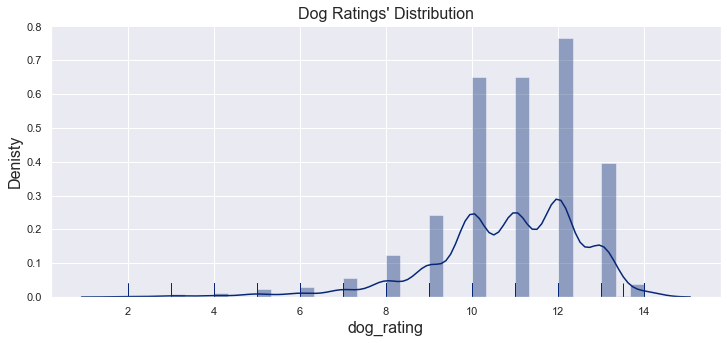

In [74]:
sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('darkgrid')
sns.distplot(df_master['dog_rating'],hist=True, kde=True, rug=True, color='#062777', vertical= False, norm_hist= False, axlabel= None, label= None)
plt.title('Dog Ratings\' Distribution', fontsize=16)
plt.xlabel('dog_rating', fontsize=16)
plt.ylabel('Denisty', fontsize=16)
plt.savefig('Dog Ratings\' Distribution.png');

* It's obivious that dogs friends are very happy with them as the most of times they rated thier dogs with at least **10** and most often to reach the score of **12**. Great!, it seems that we also a truthful friend to dogs not dogs only.

### What are the top 10 breeds based on average rating?

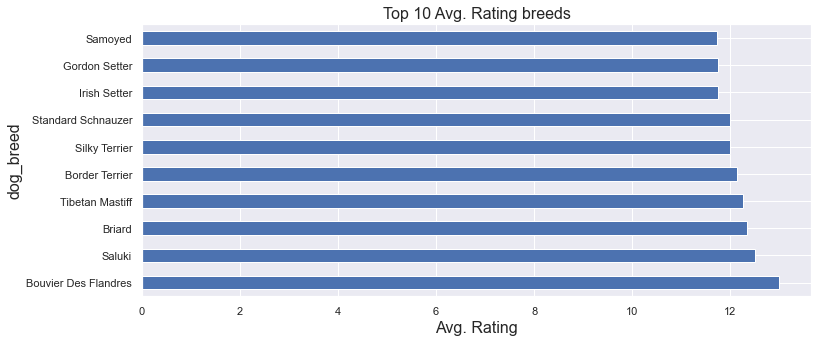

In [75]:
top10= df_master.groupby(['dog_breed']).dog_rating.mean().sort_values(ascending= False).head(10)
sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('darkgrid')
top10.plot(kind='barh')
plt.title('Top 10 Avg. Rating breeds', fontsize=16)
plt.xlabel('Avg. Rating', fontsize=16)
plt.ylabel('dog_breed', fontsize=16)
plt.savefig('Top 10 Avg. Rating breeds.png');

* Beacuse of the most rating lied between **10** and **12**, we can see that the gap is very samll between the top one and the 10th in the plot. But, we'll go further and test the rating distribution of the top10 for the seek of deep insights.

### For the identified top ten breeds, what are the distribution of each breed rating?

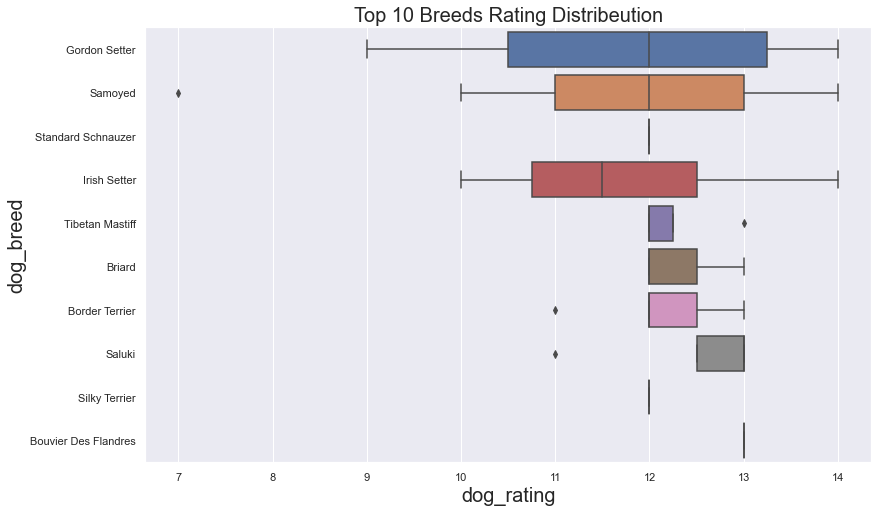

In [76]:
top10_dist=df_master.query('dog_breed == {}'.format(list(top10.index)))
sns.set(rc={'figure.figsize':(13,8)})
sns.set_style('darkgrid')
sns.boxplot(x='dog_rating', y='dog_breed',data=top10_dist,)
plt.title('Top 10 Breeds Rating Distribeution', fontsize=20)
plt.xlabel('dog_rating', fontsize=20)
plt.ylabel('dog_breed', fontsize=20)
plt.savefig('Top 10 Breeds Rating Distribution.png');

> * Distinctly, the **Gordon Setter, Samoyed**, and **Irish Setter** got the highest rating of **14**.
> * In the same time that **Samoyed** and **Irish Setter** touched the highest rate **14**, they didn't drop below rating **10** like **Gordon Setter**.
> * Great!, now we can declare our **top 3** breeds. Firstly comes **Samoyed**, this winner touched the highest rating and keep his lowest rating to be **10** plus almost **50%** of his ratings were over **12**. Secondly, comes our friend **Irish Setter** with a rate of **14** too but most of his ratings were between **11.5** and **12.5**. Lastly, the third place is for our friend too! **Gordon Setter**, as he dropped below the rate of **10** and more than **50%** of his ratings were below **12**.
> * Also, here we can see that our **Top 3 Breeds** are the last ones in the **Top 10** ranking. That is because dog breeds differ in the number of ratings, like the first two breeds as they have only one rating of **13** and **12** respectively. So, in the future, it could be more precise to set a minimum number of ratings for each breed to consider within our analysis.

### Which one of the top 3 breeds has the most fans in terms of "retweet_count" and "favorite_count"?

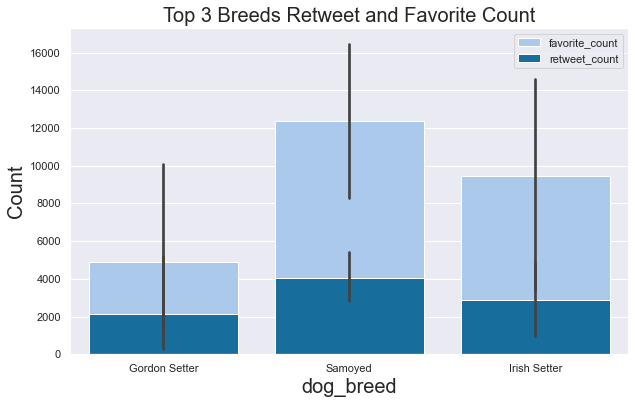

In [77]:
top3= ['Samoyed','Irish Setter','Gordon Setter']
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('darkgrid')

top3_data= df_master.query('dog_breed == {}'.format(top3)).loc[:,['dog_breed','dog_name','dog_stage','retweet_count','favorite_count', 'source']]

sns.set_color_codes("pastel")
sns.barplot(x="dog_breed", y="favorite_count", data=top3_data, label="favorite_count", color="b")
sns.set_color_codes("colorblind")
sns.barplot(x="dog_breed", y="retweet_count", data=top3_data, label="retweet_count", color="b")

plt.legend()
plt.title('Top 3 Breeds Retweet and Favorite Count', fontsize=20)
plt.xlabel('dog_breed', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.savefig('Top 3 Breeds Retweet and Favorite Count.png');

* Wow!, it seems obvious that our insights working precisely **Samoyed**, **Irish Setter**, and **Gordon Setter**, and, luckily, they take the same shape as the Olympic game ranking!.

### Now, let's finish this perspective up and see what's the most common tweeting sources for each one of them?

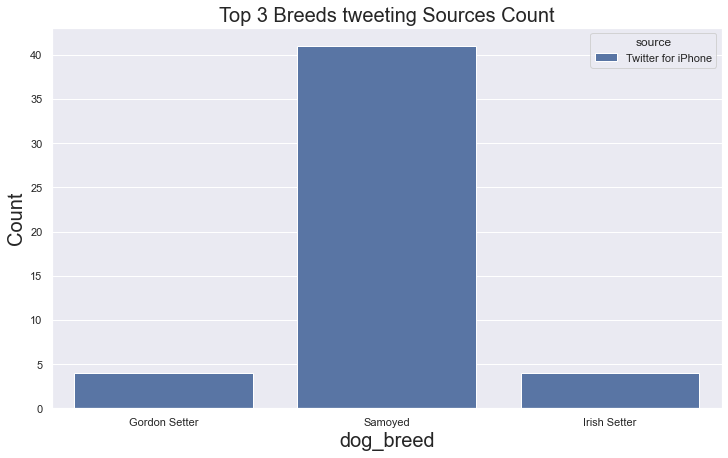

In [78]:
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('darkgrid')

sns.countplot(data=top3_data, x = 'dog_breed', hue='source')

plt.title('Top 3 Breeds tweeting Sources Count', fontsize=20)
plt.xlabel('dog_breed', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.savefig('Top 3 Breeds tweeting Sources Count.png');

* For the top 3 breeds, **Twitter for iPhone** was the most common way for these breeds lovers to share their moments with them. But, obiviously, it proving that dog breed **Samoyed** the mentioned one.

## Now let's perform some holistic insights.

### What is the most common dog stage?

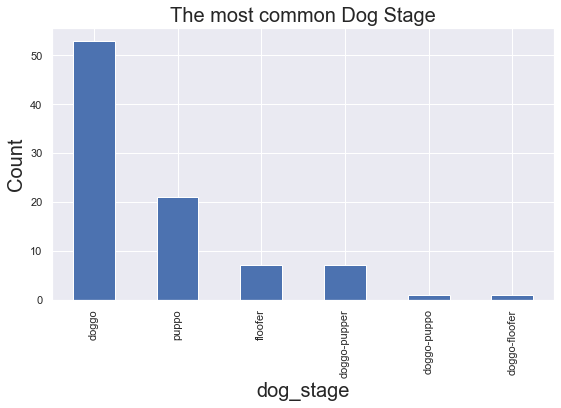

In [96]:
sns.set(rc={'figure.figsize':(9,5)})
sns.set_style('darkgrid')

df_master.dog_stage.value_counts()[1:].plot(kind='bar')

plt.title('The most common Dog Stage', fontsize=20)
plt.xlabel('dog_stage', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.savefig('The most common Dog Stage.png');

* Pet lovers preferred to breeding **Doggo** in the first stage and **Puppo** secondly.

### Which Dog Stage has the most "Retweet" and "Favorite" count among the others?

In [80]:
df_master.dog_stage.notnull().sum()

255

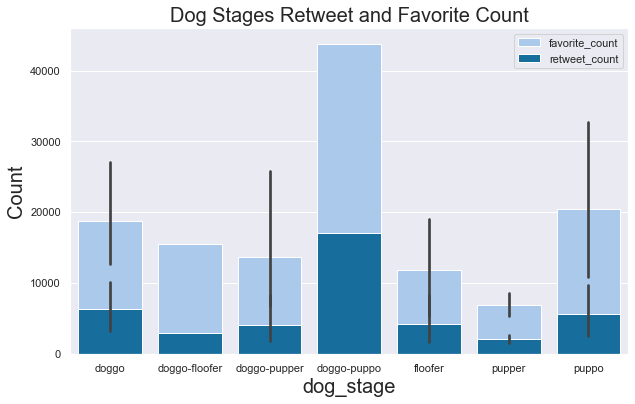

In [81]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('darkgrid')

sns.set_color_codes("pastel")
sns.barplot(x='dog_stage', y="favorite_count", data=df_master, label="favorite_count", color="b")
sns.set_color_codes("colorblind")
sns.barplot(x='dog_stage', y="retweet_count", data=df_master, label="retweet_count", color="b")

plt.legend()
plt.title('Dog Stages Retweet and Favorite Count', fontsize=20)
plt.xlabel('dog_stage', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.savefig('Dog Stages Retweet and Favorite Count.png');

* While **Doggo** is the most mentioned dog stage but it isn't the most stage with neither **Retweet** nor **Favorite** count.
* Dog stage **Doggo-Puppo** is the most liked stage, followed by **Puppo** then **Doggo**. Surprisingly, it's almost the same stage.
* But, regarding the most retweeted, it shows that dog stage **Doggo-Puppo** comes first too, followed by **Doggo** then **Puppo**, but, with strong presence of **Floofer** and **Doggo-Pupper**.

### What is the most frequent dog name?

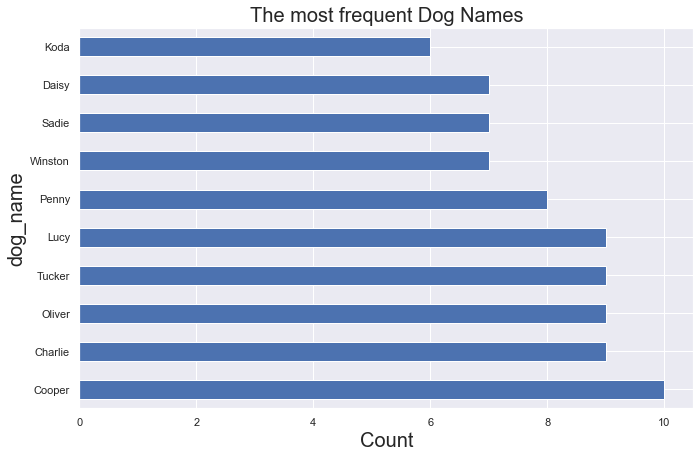

In [92]:
sns.set(rc={'figure.figsize':(11,7)})
sns.set_style('darkgrid')

df_master.query('dog_name != ["None","a","the"]').dog_name.value_counts()[0:10].plot(kind='barh')

plt.title('The most frequent Dog Names', fontsize=20)
plt.xlabel('Count', fontsize=20)
plt.ylabel('dog_name', fontsize=20)
plt.savefig('The most frequent Dog Names.png');

* **Cooper** comes first then **Charlie**, **Oliver**, **Tucker**, and **Lucy** seem to be the most frequent dog name. But, in the same time, **Penny** isn't far away from them.

### What is the corelation between "retweet count" and "favorite count"?

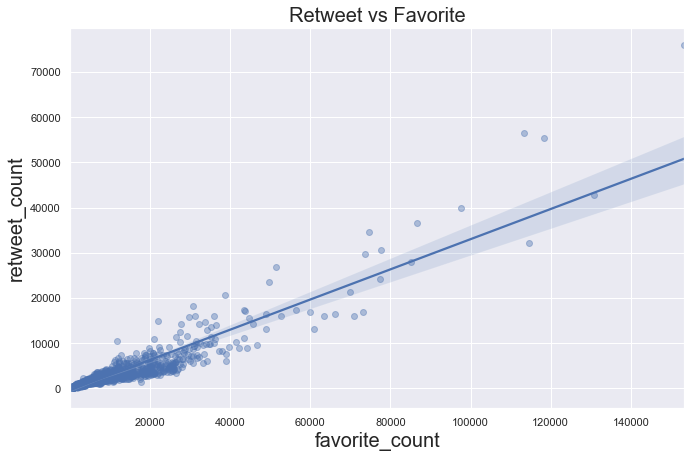

In [83]:
sns.set(rc={'figure.figsize':(11,7)})
sns.set_style('darkgrid')

sns.regplot(x="favorite_count", y="retweet_count", data=df_master, dropna=True, scatter_kws={'alpha':0.4})

plt.title('Retweet vs Favorite', fontsize=20)
plt.xlabel('favorite_count', fontsize=20)
plt.ylabel('retweet_count', fontsize=20)
plt.savefig('Retweet vs Favorite.png');

* Plot shows a very strong positive correlation between retweets and favorite count.
* It's reasonable and common sense that as the tweet gets more likes (favorites) it becomes more probable to retweet.

### Finally What words Dog Lovers used commonly to share their moments with their dogs?

(-0.5, 1023.5, 729.5, -0.5)

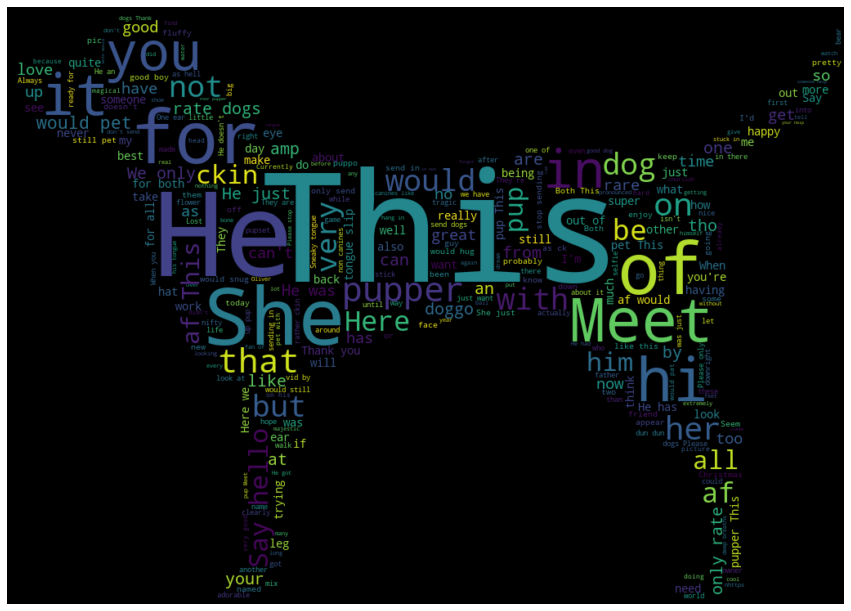

In [84]:
sns.set(rc={'figure.figsize':(15,15)})
text = df_master.text.to_string(index =False).replace('/','').strip()
url = 'https://media.istockphoto.com/vectors/labrador-retriever-dog-vector-black-silhouette-vector-id484224854'
r = requests.get(url)
mask = np.array(Image.open(BytesIO(r.content)))
stopwords = ('and','is','the','to')
wc= WordCloud(width=400,height=200,background_color='black',mask=mask,stopwords=stopwords,max_words=300,contour_color='white')
wc.generate(text)
wc.to_file('Dogs Word Cloud.png')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

* Nice!, Dog lovers tend to friendly introduce their mates with the word **This** and a little bit with the word **Meet**.
* Also, it seems that most of the tweeted dogs were male which could be considered an indicator that most of the breeders were females!.
* **Pupper** is the most dog stage represented through our dataset of tweets, this fact could be considered as strong evidence to prove our previous insight of that most of the breeders were females!.